Happiness, Wealth, and Alcohol Consumption

My first data analytics and machine learning project tackling a topic of particular interest to me. This will be the first of many commitments towards becoming proficient enough in programming in preparation for my MSDS program in AIM.

Giving credit to my former colleague, Hadrian Ang, for providing such a comprehensive guide to data analytics. Parts of this analysis are based heavily on his work.

In [1]:
#import all relevant libraries
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import numpy as np 
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [2]:
%matplotlib inline

Load the dataset from Kaggle. Let's check it out a bit!

In [3]:
s2 = pd.read_csv('HappinessAlcoholConsumption.csv')

In [4]:
s2.head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53.579,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79.866,185,100,280
2,Iceland,Western Europe,north,7.501,933,60.530,233,61,78
3,Norway,Western Europe,north,7.498,951,70.890,169,71,129
4,Finland,Western Europe,north,7.413,918,43.433,263,133,97


In [5]:
s2.describe()

,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,5.524828,740.877049,91.482836,137.565574,96.598361,66.598361
std,1.148736,149.846124,209.577313,104.817353,81.435028,88.121503
min,3.069000,351.000000,1.029000,1.000000,1.000000,1.000000
25%,4.528250,663.750000,4.134250,38.250000,25.500000,5.000000
50%,5.542000,757.500000,12.016000,125.500000,82.500000,16.000000
75%,6.477000,861.500000,41.990000,224.750000,142.500000,112.750000
max,7.526000,951.000000,953.000000,376.000000,373.000000,370.000000


In [6]:
corr = s2.corr()

Some simple correlation analysis to get us started

In [7]:
corr

,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
HappinessScore,1.000000,0.815163,-0.451425,0.493367,0.256399,0.450589
HDI,0.815163,1.000000,-0.573734,0.588394,0.393413,0.602561
GDP_PerCapita,-0.451425,-0.573734,1.000000,-0.369936,-0.260818,-0.200154
Beer_PerCapita,0.493367,0.588394,-0.369936,1.000000,0.364855,0.474274
Spirit_PerCapita,0.256399,0.393413,-0.260818,0.364855,1.000000,0.118718
Wine_PerCapita,0.450589,0.602561,-0.200154,0.474274,0.118718,1.000000


Simple visualization should help us inspect the data.

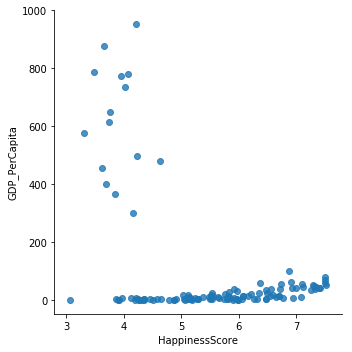

In [8]:
sns.lmplot('HappinessScore', 'GDP_PerCapita', data = s2, fit_reg = False)

I guess on first glance, the richer people are in a country, the lower the happiness score seems to be? Simply based on common sense, something's off here.

It might have something to do with those stray dots though. Happiness isn't correlated with personal wealth? Weird, right?

Let's group everyone by region first and see.

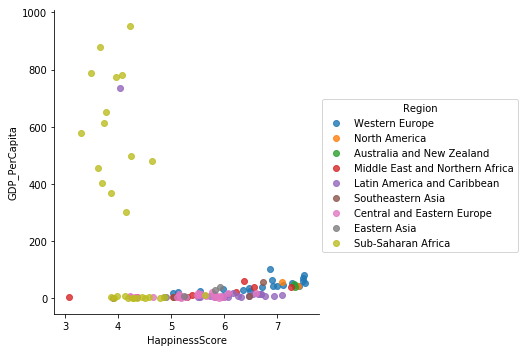

In [9]:
sns.lmplot('HappinessScore', 'GDP_PerCapita', data = s2, hue = 'Region', fit_reg = False)

It seems the Sub-Saharan Africa region is full of outliers for some reason. This may have something to do with their population. Let's address these outliers later. Let's group them by hemisphere as well to check.

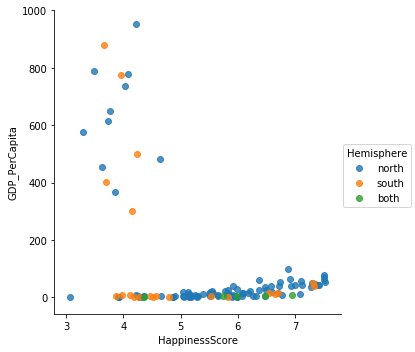

In [10]:
sns.lmplot('HappinessScore', 'GDP_PerCapita', data = s2, hue='Hemisphere', fit_reg = False)

Once again, not counting the outliers, it seems that countries from the north hemisphere tend to be happier than ones from the south. We'll want to identify and address those outliers first if we're getting anything meaningful out of this analysis.

We can first focus on those countries with really high GDP Per Capita and what exactly is going on with them.

In [11]:
s2[s2['GDP_PerCapita'] > 200]

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
89,Sierra Leone,Sub-Saharan Africa,north,4.635,413,481.0,25,3,2
100,Rep. Congo,Sub-Saharan Africa,south,4.236,612,498.0,76,1,9
101,Senegal,Sub-Saharan Africa,north,4.219,499,953.0,9,1,7
104,Malawi,Sub-Saharan Africa,south,4.156,474,300.0,8,11,1
106,Mali,Sub-Saharan Africa,north,4.073,421,780.0,5,1,1
107,Haiti,Latin America and Caribbean,north,4.028,496,735.0,1,326,1
109,Comoros,Sub-Saharan Africa,south,3.956,502,775.0,1,3,1
113,Niger,Sub-Saharan Africa,north,3.856,351,368.0,3,2,1
114,Chad,Sub-Saharan Africa,north,3.763,405,651.0,15,1,1
115,Burkina Faso,Sub-Saharan Africa,north,3.739,420,614.0,25,7,7


These are those dots high up in the graph earlier. For the sake of simplicity, let's drop them from the dataset.

In [12]:
df = s2[s2['GDP_PerCapita'] < 200]

You can exempt the the previous selection by simply flipping the inequality sign. Now, everything selected as 'df' doesn't include those outliers. Let's check the remaining Sub-Saharan African countries just to be sure.

In [13]:
df[df['Region']=='Sub-Saharan Africa']

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
58,Mauritius,Sub-Saharan Africa,north,5.648,788,9.682,98,31,18
85,Nigeria,Sub-Saharan Africa,north,4.875,530,2.176,42,5,2
87,Zambia,Sub-Saharan Africa,south,4.795,586,1.263,32,19,4
90,Namibia,Sub-Saharan Africa,south,4.574,645,4.561,376,3,1
91,Cameroon,Sub-Saharan Africa,south,4.513,553,1.375,147,1,4
92,South Africa,Sub-Saharan Africa,south,4.459,696,5.280,225,76,81
95,Kenya,Sub-Saharan Africa,both,4.356,585,1.463,58,22,2
97,Ghana,Sub-Saharan Africa,north,4.276,588,1.517,31,3,10
98,Dem. Rep. Congo,Sub-Saharan Africa,south,4.272,452,1.712,32,3,1
103,Zimbabwe,Sub-Saharan Africa,south,4.193,532,1.029,64,18,4


Let's do another correlation plot and see if anything's changed.

In [14]:
corr2 = df.corr()
corr2

,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
HappinessScore,1.000000,0.750734,0.707743,0.356639,0.143246,0.383592
HDI,0.750734,1.000000,0.748954,0.459138,0.316044,0.606243
GDP_PerCapita,0.707743,0.748954,1.000000,0.311744,-0.000808,0.552332
Beer_PerCapita,0.356639,0.459138,0.311744,1.000000,0.316896,0.415621
Spirit_PerCapita,0.143246,0.316044,-0.000808,0.316896,1.000000,0.054223
Wine_PerCapita,0.383592,0.606243,0.552332,0.415621,0.054223,1.000000


This seems to be better, plus it makes a whole lot more sense. Let's compare it with our previous correlation

In [15]:
corr

,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
HappinessScore,1.000000,0.815163,-0.451425,0.493367,0.256399,0.450589
HDI,0.815163,1.000000,-0.573734,0.588394,0.393413,0.602561
GDP_PerCapita,-0.451425,-0.573734,1.000000,-0.369936,-0.260818,-0.200154
Beer_PerCapita,0.493367,0.588394,-0.369936,1.000000,0.364855,0.474274
Spirit_PerCapita,0.256399,0.393413,-0.260818,0.364855,1.000000,0.118718
Wine_PerCapita,0.450589,0.602561,-0.200154,0.474274,0.118718,1.000000


Better, right? Let's get a better look at how the Happiness Index is correlated with our other variables.

In [16]:
corr2['HappinessScore']

HappinessScore      1.000000
HDI                 0.750734
GDP_PerCapita       0.707743
Beer_PerCapita      0.356639
Spirit_PerCapita    0.143246
Wine_PerCapita      0.383592
Name: HappinessScore, dtype: float64

This highlights the importance of finding outliers and anomalies in your data before running any meaningful analyses.

Let's take another look at our data.

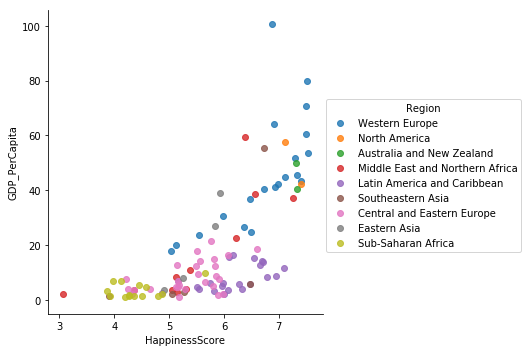

In [17]:
sns.lmplot('HappinessScore', 'GDP_PerCapita', data = df, hue = 'Region', fit_reg = False)

Now that the plot's scaling looks more readable, we can more easily analyze at it. We can see here that wealth and happiness do move up together, but the concentration of points around the bottom implies that countries need not necessarily be wealthy to be happy.

Let's take another look at the same graph colored by hemisphere.

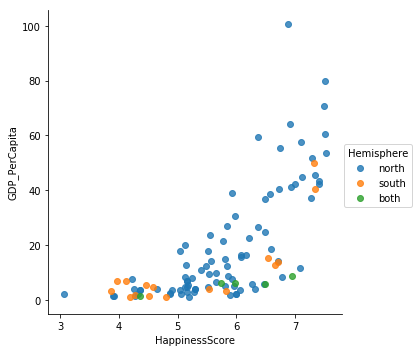

In [18]:
sns.lmplot('HappinessScore', 'GDP_PerCapita', data = df, hue = 'Hemisphere', fit_reg = False)

Seems like a lot of countries on the northern hemisphere are quite wealthy, but not necessarily happy. Let's take quick look at which countries are happiest!

In [19]:
df[df['HappinessScore'] > 6].head(10)

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53.579,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79.866,185,100,280
2,Iceland,Western Europe,north,7.501,933,60.530,233,61,78
3,Norway,Western Europe,north,7.498,951,70.890,169,71,129
4,Finland,Western Europe,north,7.413,918,43.433,263,133,97
5,Canada,North America,north,7.404,922,42.349,240,122,100
6,Netherlands,Western Europe,north,7.339,928,45.638,251,88,190
7,New Zealand,Australia and New Zealand,south,7.334,915,40.332,203,79,175
8,Australia,Australia and New Zealand,south,7.313,938,49.897,261,72,212
9,Sweden,Western Europe,north,7.291,932,51.845,152,60,186


Europe seems to be a happy place, but we all knew that. What about Asia?

Notice also how they're quite well off based on GDP per capita. Spirits seem to be the least popular, but Europe is understandably big on wine and beer. Let's check the correlations of GDP Per Capita with consumption.

In [20]:
corr2['GDP_PerCapita']

HappinessScore      0.707743
HDI                 0.748954
GDP_PerCapita       1.000000
Beer_PerCapita      0.311744
Spirit_PerCapita   -0.000808
Wine_PerCapita      0.552332
Name: GDP_PerCapita, dtype: float64

Cool! We can infer from this that wealth may have something to do with beer and wine consumption, but not necessarily spirits. Maybe less well-off countries prefer spirits? (Ginebra Gin and Tanduay Rum come to mind)

In [21]:
df[df['Region'].str.contains('Asia')]

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
20,Singapore,Southeastern Asia,north,6.739,930,55.243,60,12,11
31,Thailand,Southeastern Asia,north,6.474,748,5.979,99,258,1
46,Japan,Eastern Asia,north,5.921,907,38.972,77,202,16
51,South Korea,Eastern Asia,north,5.835,900,27.105,140,16,9
69,Philippines,Southeastern Asia,north,5.279,696,2.951,71,186,1
70,China,Eastern Asia,north,5.245,748,8.117,79,192,8
81,Vietnam,Southeastern Asia,north,5.061,689,2.171,111,2,1
84,Mongolia,Eastern Asia,north,4.907,743,3.694,77,189,8
111,Cambodia,Southeastern Asia,north,3.907,576,1.270,57,65,1


Congratulations! You now know that an average Japanese person is roughly 13 times wealthier than a Filipino. It's also worth noting that Thailand is much happier than its richer neighbors. Meanwhile, China is just as happy as the Philippines despite being much better off. 

We can now also see which countries prefer which types of alcohol. It's understandable that asia isn't big on wine, but look at how crazy spirit consumption is! It's generally higher than beer, except in places like South Korea and Vietnam. 

Singapore doesn't seem to consume much alcohol but it might also be attributed to their population. That, or they're just boring people. Who knows!

Let's summarize what we learned so far:
1. Higher personal wealth and a high Human Development Index Score are correlated with happiness.
2. The skewedness of the data however implies that more wealth is not necessarily a requirement for a population to be happy.
3. Alcohol consumption is positively correlated with happiness and wealth (except spirits), although the relationship is quite weak.

So far, we've done some pretty basic stuff that you can actually do quite easily on MS Excel. Let's move on to linear regression.

In [22]:
df.dtypes

Country              object
Region               object
Hemisphere           object
HappinessScore      float64
HDI                   int64
GDP_PerCapita       float64
Beer_PerCapita        int64
Spirit_PerCapita      int64
Wine_PerCapita        int64
dtype: object

We'll first remove non-numeric data from our dataframe to more easily do our regression

In [23]:
num_df = df.select_dtypes(include=['int64', 'float64'])
num_df.head()

,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,7.526,928,53.579,224,81,278
1,7.509,943,79.866,185,100,280
2,7.501,933,60.530,233,61,78
3,7.498,951,70.890,169,71,129
4,7.413,918,43.433,263,133,97


Wow! Now let's prepare the data for regression with Happiness as our dependent variable.

In [24]:
X = num_df.drop(['HappinessScore'], axis=1)
y = num_df['HappinessScore']

Now let's split our data into a training and a test set. Basically, training data lets the computer learn patterns in the data, then it evaluates using the test set. The parameters below indicate that we'll use 50% of the data for training, and 50% for testing. We can adjust these later for experimentation. Let's try it out!

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 30, train_size = 0.5)

C:\Users\Batmand44\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [26]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Now that we did some regression, let's look at the results.

In [27]:
#I honestly do not know what on earth is going on here, but it seems to work.
pd.DataFrame([{column: cof for column, cof in zip(X_train.columns, list(model.coef_))}], 
             index=['Coefficient']).transpose().sort_values('Coefficient', ascending = False)

,Coefficient
GDP_PerCapita,0.010762
HDI,0.007375
Beer_PerCapita,0.000264
Spirit_PerCapita,-0.001506
Wine_PerCapita,-0.003791


Okay, this seems a bit weird, but that's okay! We didn't scale our values yet. GDP/capita is in dollars, while alcohol consumption is in Liters/Person. Scaling makes sure the data's values are all measured in uniform. We'll be using the z-score for scaling, which is basically (value - mean) / standard dev.

In [28]:
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = list(X_train.columns), index = X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = list(X_test.columns), index = X_test.index)

C:\Users\Batmand44\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Batmand44\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Batmand44\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


wew. Let's not worry about that. That just means the values have been altered by the scaling.

In [29]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
pd.DataFrame([{column: cof for column, cof in zip(X_train.columns, list(model.coef_))}], 
             index=['Coefficient']).transpose().sort_values('Coefficient', ascending = False)

,Coefficient
HDI,0.862211
GDP_PerCapita,0.228759
Beer_PerCapita,0.026049
Spirit_PerCapita,-0.115090
Wine_PerCapita,-0.336122


Welp. That's weird, but let's take a look. We're quite aware from earlier that wine is heavily consumed in happier countries, so that negative coefficient seems off. In analysis like this one, it's also useful to trust your intuition and not just the numbers. 

Let's try something else. I'm more comfortable with statsmodels due to my economics background, so we can see how that works.

In [30]:
num_df.head()

,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,7.526,928,53.579,224,81,278
1,7.509,943,79.866,185,100,280
2,7.501,933,60.530,233,61,78
3,7.498,951,70.890,169,71,129
4,7.413,918,43.433,263,133,97


In [31]:
reg1 = smf.ols(formula = 'HappinessScore ~ GDP_PerCapita + Beer_PerCapita', data = num_df)
res = reg1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     56.65
Date:                Sun, 02 Dec 2018   Prob (F-statistic):           2.29e-17
Time:                        12:59:17   Log-Likelihood:                -115.15
No. Observations:                 107   AIC:                             236.3
Df Residuals:                     104   BIC:                             244.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.9210      0.130     37.786      0.000       4.663       5.179
GDP_PerCapita      0.0335      0.004      9.255      0.000       0.026       0.041
Beer_PerCapita     0.0015      0.001      2.110      0.037     9.2e-05       0.003
==============================================================================
Omnibus:                        2.100   Durbin-Watson:                   0.858
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.947
Skew:                          -0.329   Prob(JB):                        0.378
Kurtosis:                       2.932   Cond. No.                         346.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is a much better summary, but our results are still weird. Let's scale the data again, this time with normalization. That means we'll scale it from values of 0 to 1.

In [32]:
num_df.head()

,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,7.526,928,53.579,224,81,278
1,7.509,943,79.866,185,100,280
2,7.501,933,60.530,233,61,78
3,7.498,951,70.890,169,71,129
4,7.413,918,43.433,263,133,97


In [35]:
from sklearn.preprocessing import scale

In [37]:
scaled = MinMaxScaler()

In [38]:
num_df_s = scaled.fit_transform(num_df)

C:\Users\Batmand44\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


I'm using this data in statsmodels and I only know how to do that with a dataframe. The transformation turned my data into a numpy array, so let's turn it back into a dataframe.

Another problem with the scaling thing: you remove the column headings when you scale data since it becomes an array first. Let's get them back using the code below.

Basically, we set the columns headings to match the non-scaled dataframe with the new one. Skipping out on the code in the parenthesis will result in the headings turning into numbers (0, 1 ,2, etc.)

In [47]:
df2 = pd.DataFrame(num_df_s, columns = num_df.columns)
df2.head()

,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,1.000000,0.953908,0.527028,0.594667,0.215054,0.750678
1,0.996186,0.983968,0.790663,0.490667,0.266129,0.756098
2,0.994391,0.963928,0.596741,0.618667,0.161290,0.208672
3,0.993718,1.000000,0.700642,0.448000,0.188172,0.346883
4,0.974647,0.933868,0.425273,0.698667,0.354839,0.260163


Now that we have our dataframe scaled, let's do linear regression again.

In [51]:
reg2 = smf.ols(formula = 'HappinessScore ~ GDP_PerCapita + Beer_PerCapita', data = df2)
res2 = reg2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     56.65
Date:                Sun, 02 Dec 2018   Prob (F-statistic):           2.29e-17
Time:                        14:30:08   Log-Likelihood:                 44.755
No. Observations:                 107   AIC:                            -83.51
Df Residuals:                     104   BIC:                            -75.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4236      0.029     14.645      0.000       0.366       0.481
GDP_PerCapita      0.7501      0.081      9.255      0.000       0.589       0.911
Beer_PerCapita     0.1287      0.061      2.110      0.037       0.008       0.250
==============================================================================
Omnibus:                        2.100   Durbin-Watson:                   0.858
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.947
Skew:                          -0.329   Prob(JB):                        0.378
Kurtosis:                       2.932   Cond. No.                         5.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, there's a lot going on with the numbers here and you're probably wondering what they mean.

1. <b> R-squared </b> - basically, this tells us what percent of the variance of our dependent variable is explained by the independent variables.  As a rule of thumb, higher R-squared values are generally more desirable, but lower values are perfectly fine when your variables are more likely to be more spread out (like in this case, we're predicting human behavior). In our case, it means that 52.1% of the variance of Happiness is explained by GDP/Capita and Beer/Capita.
<br>
</br>
<br>
</br>
2. <b> Coef </b> - coef stands for coefficient. This is how much the dependent variable is affected by the independent variables. For this regression, it means that for every unit increase in beer consumption per capita, then happiness goes up by 0.1287 units. The scaled data makes this a bit more difficult to interpret, but let's deal with that issue later.
<br>
</br>
<br>
</br>
3. <b> P>|t| </b> - a variable is statistically significant if this value is below a certain number. Usually we set it was 5%, or 0.05. For now, let's just say that any value below 0.05 is a good thing. 

In [52]:
reg2 = smf.ols(formula = 'HappinessScore ~ GDP_PerCapita + Spirit_PerCapita', data = df2)
res2 = reg2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     56.69
Date:                Sun, 02 Dec 2018   Prob (F-statistic):           2.24e-17
Time:                        15:45:32   Log-Likelihood:                 44.777
No. Observations:                 107   AIC:                            -83.55
Df Residuals:                     104   BIC:                            -75.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4221      0.029     14.373      0.000       0.364       0.480
GDP_PerCapita        0.8035      0.077     10.437      0.000       0.651       0.956
Spirit_PerCapita     0.1607      0.076      2.120      0.036       0.010       0.311
==============================================================================
Omnibus:                        1.248   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.536   Jarque-Bera (JB):                1.049
Skew:                          -0.242   Prob(JB):                        0.592
Kurtosis:                       2.999   Cond. No.                         5.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
reg2 = smf.ols(formula = 'HappinessScore ~ GDP_PerCapita + Wine_PerCapita', data = df2)
res2 = reg2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         HappinessScore   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     52.20
Date:                Sun, 02 Dec 2018   Prob (F-statistic):           2.01e-16
Time:                        15:45:47   Log-Likelihood:                 42.521
No. Observations:                 107   AIC:                            -79.04
Df Residuals:                     104   BIC:                            -71.02
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4680      0.022     21.412      0.000       0.425       0.511
GDP_PerCapita      0.8100      0.094      8.587      0.000       0.623       0.997
Wine_PerCapita    -0.0099      0.078     -0.127      0.899      -0.165       0.145
==============================================================================
Omnibus:                        1.807   Durbin-Watson:                   0.853
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                1.690
Skew:                          -0.305   Prob(JB):                        0.430
Kurtosis:                       2.913   Cond. No.                         7.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Seems that Beer and Spirit have SOMETHING to do with happiness, but wine does not (see p-value).